In [1]:
import pandas as pd
from sklearn.metrics import mean_squared_error as MSE
from math import sqrt
import itertools
import warnings
import statsmodels.api as sm
import statsmodels
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm

Let's see the data:

In [2]:
df2 = pd.read_pickle("GDP_temperature_anomalies_1947_USA.pkl")
df2 = df2.reset_index()
df2['time'] = pd.to_datetime(df2['time'])
df2 = df2.set_index(df2['time'])
df2 = df2.sort_index()
df2 =  df2.drop(["time","index","gdp"], axis =1)

In [27]:
df2

,timeMin,timeMax
time,,
1947-01-15,-6.66,4.33
1947-02-15,-3.48,3.51
1947-03-15,-3.64,4.59
1947-04-15,-1.90,1.61
1947-05-15,-2.55,2.46
...,...,...
2020-12-15,-0.27,5.58
2021-01-15,0.48,7.10
2021-02-15,-4.14,1.27


Let's only analyze timeMax, the Max temperature anomaly time series among all weather station in the selected country for every month

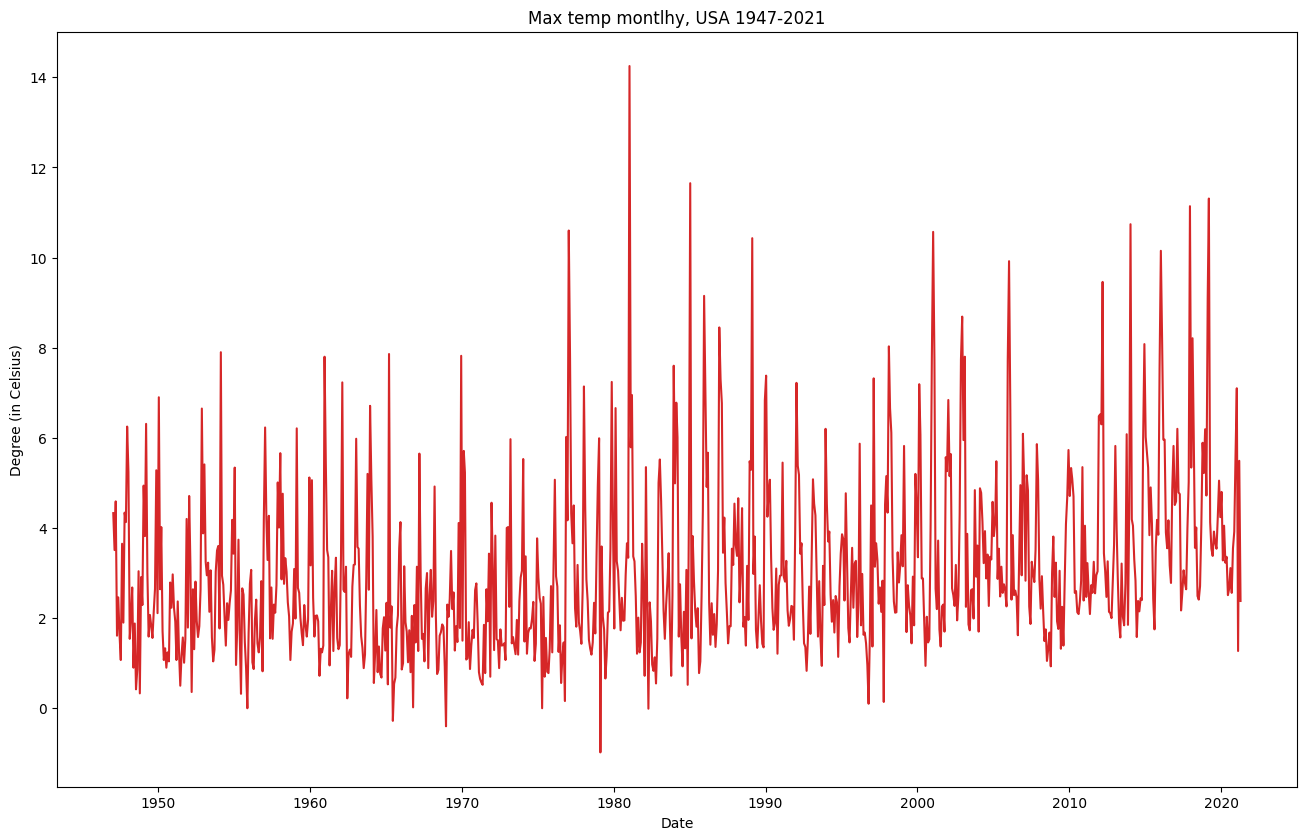

In [3]:
plt.figure(figsize=(16,10), dpi=100)
plt.plot(df2.index, df2.timeMax, color='tab:red')
plt.gca().set(title="Max temp montlhy, USA 1947-2021", xlabel='Date', ylabel="Degree (in Celsius)")
plt.show()

It may be useful to plot the moving average by a subset of time in order to focus on more longer trends

<AxesSubplot:xlabel='time'>

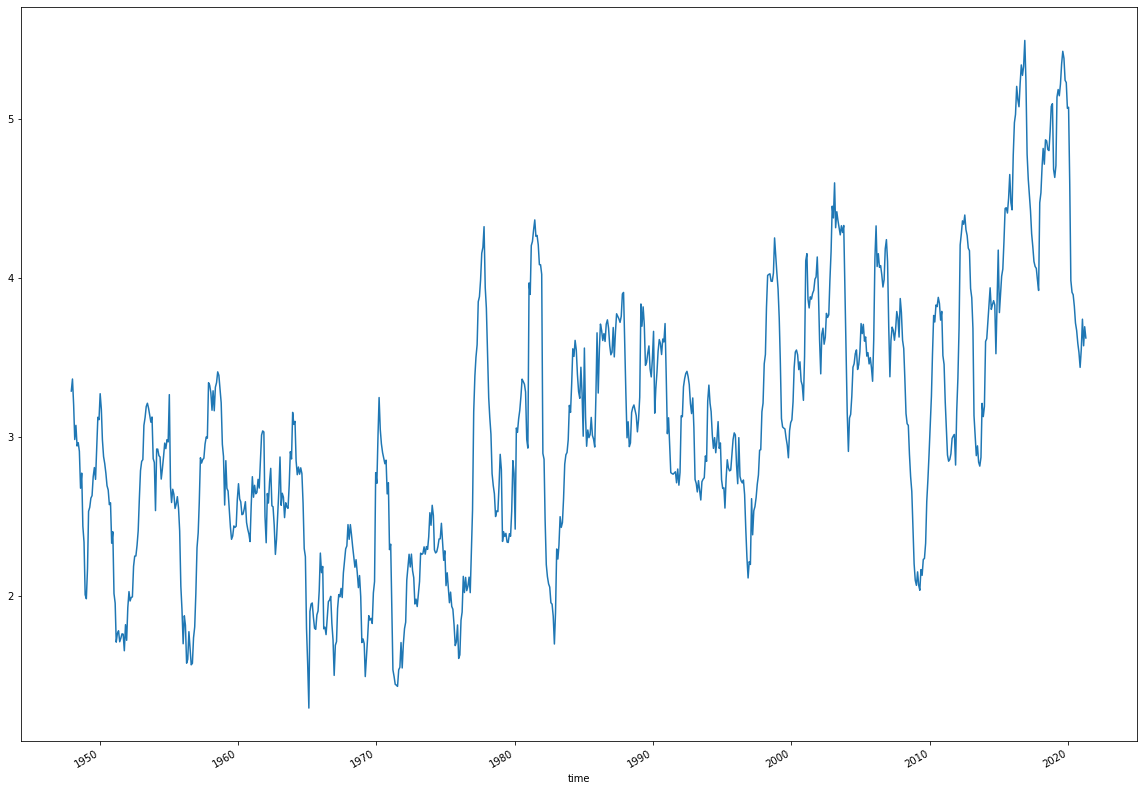

In [13]:
# Apply the Moving Average function by a subset of size 1 year to timeMax.
temp_df_mean = df2.timeMax.rolling(window=12).mean()
temp_df_mean.plot(figsize=(20,15))

<AxesSubplot:xlabel='time'>

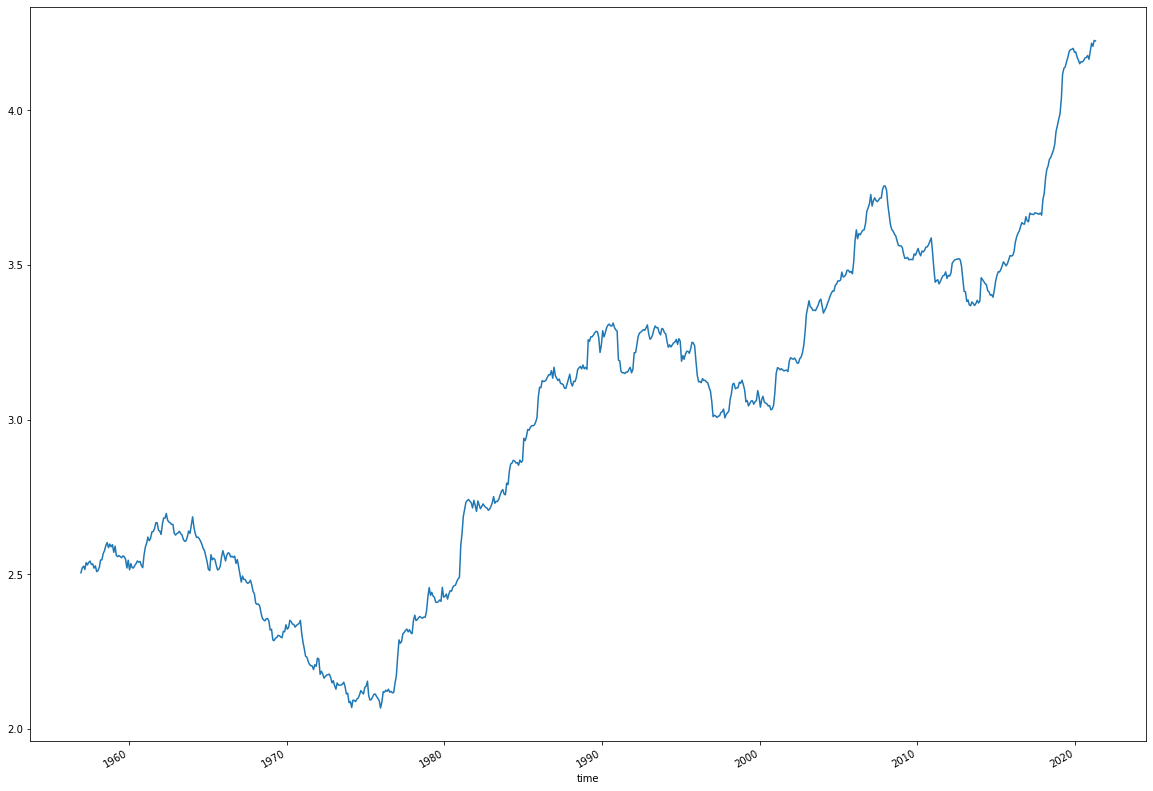

In [10]:
# Apply the Moving Average function by a subset of size 10 years to timeMax.
temp_df_mean = df2.timeMax.rolling(window=120).mean()
temp_df_mean.plot(figsize=(20,15))

If we take a shorter period, it can be seen that actually the maximum values of max temperature anomalies, appear mostly in winter months, meaning that, since the trend shows an increase, that the exceptional changes with respect to the baseline, result in warmer winters.

<AxesSubplot:xlabel='time'>

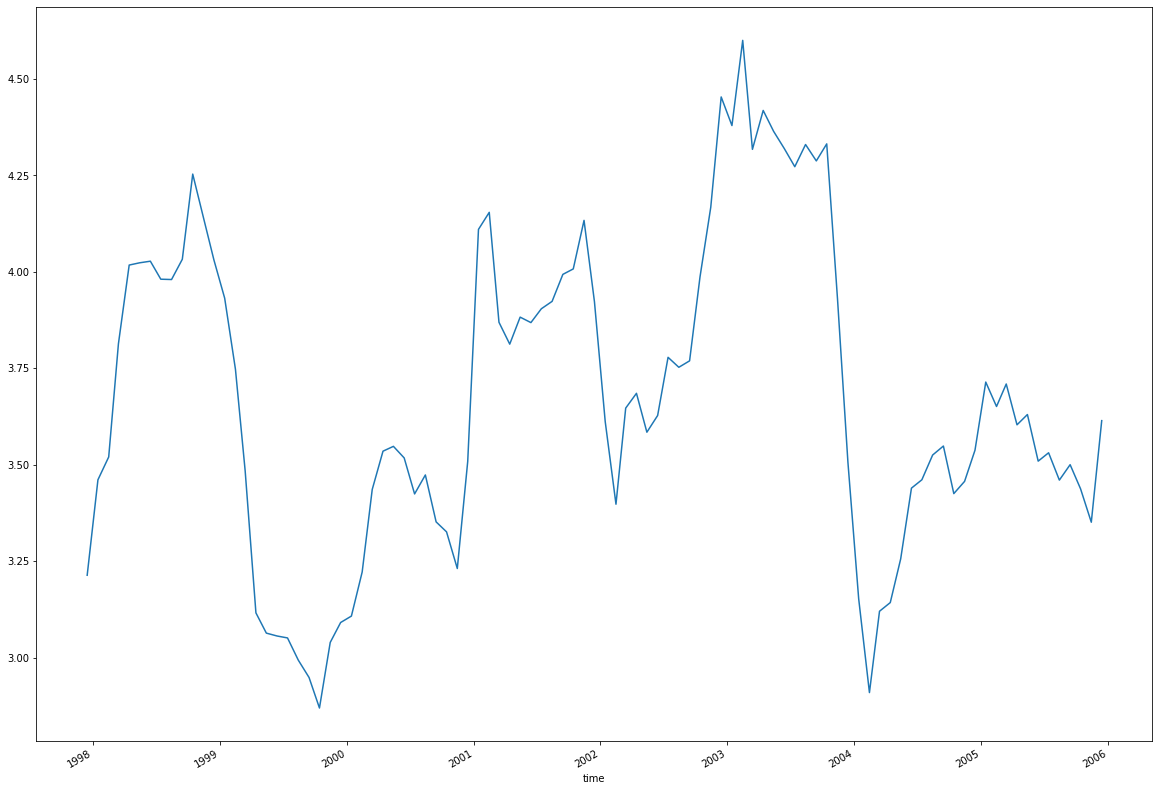

In [23]:
temp_df_mean = df2.timeMax['1997':'2005'].rolling(window=12).mean()
temp_df_mean.plot(figsize=(20,15))

When the goal is to study a time series one method is to apply a seasonality decomposition (here of 12 months). Again substructing from the original time series, the seosonal component, it can be seen that there seem to be an increasing trend in the monthly maximum temperature anomalies: 

<ipython-input-5-c2a246514cff>:5: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  result_add = seasonal_decompose(df2.timeMax, model='additive', extrapolate_trend='freq', freq=12)


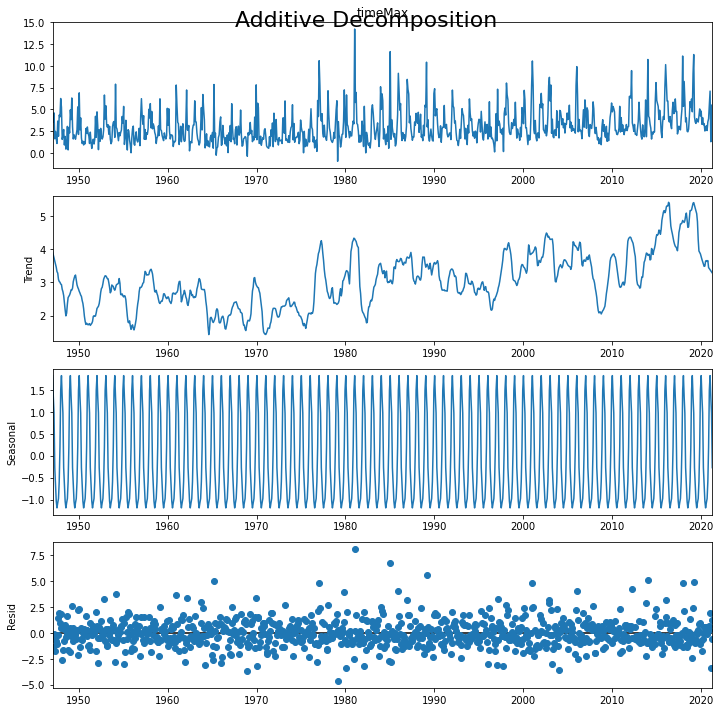

In [5]:
#FOR time MAX
from statsmodels.tsa.seasonal import seasonal_decompose

# Additive Decomposition
result_add = seasonal_decompose(df2.timeMax, model='additive', extrapolate_trend='freq', freq=12)

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_add.plot().suptitle('Additive Decomposition', fontsize=22)
plt.show()

In [25]:
dfMax = df2.drop(["timeMin"], axis =1)
#dfMin = df2.drop(["timeMax"], axis =1)

Before running a model like the Sarimax, the stationarity of the timeseries should be checked. Here the Augmented Dickey–Fuller test has been performed and it can be seen that null hypothesis is rejected meaning that the data does not have a unit root and it is stationary.

In [28]:
result =adfuller(dfMax)

print('ADF statistics: %f' % result[0])
print('pvalue: %f' % result[1])
print('Critical values:')
for key,value in result[4].items():
    print('\t%s: %.3f' % (key,value))

ADF statistics: -3.701988
pvalue: 0.004085
Critical values:
	1%: -3.438
	5%: -2.865
	10%: -2.569


In order to find the best parameter for the seasonality component the Autocorellation and Partial autocorellations plots can be analysed. Both suggest that a seasonality of 12 months may be a good choice.

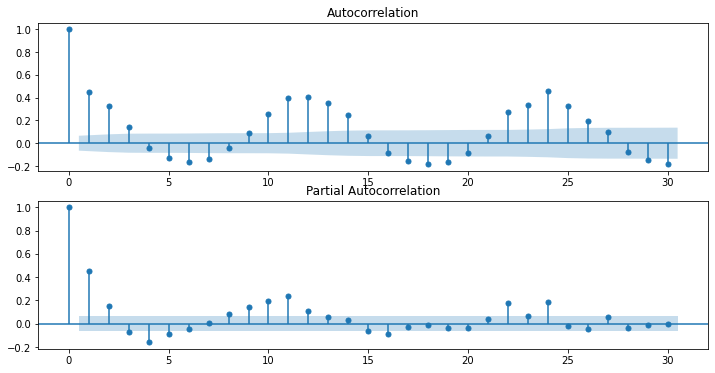

In [35]:
fig,ax = plt.subplots(2, figsize=(12,6))
ax[0]= plot_acf(dfMax, ax=ax[0],lags=30)
ax[1]= plot_pacf(dfMax, ax=ax[1],lags=30)

--------------------------------------------------------MODEL---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Test set of 1 year to get a prediction on it and evaluate the model performance.

In [26]:
train = dfMax.copy()
test = dfMax[(len(dfMax)-12):]
train[-12:] = float("NAN")

In [57]:
train

,timeMax
time,
1947-01-15,4.33
1947-02-15,3.51
1947-03-15,4.59
1947-04-15,1.61
1947-05-15,2.46
...,...
2020-12-15,NaN
2021-01-15,NaN
2021-02-15,NaN


In [58]:
test

,timeMax
time,
2020-05-15,3.36
2020-06-15,2.51
2020-07-15,2.65
2020-08-15,3.11
2020-09-15,2.56
2020-10-15,3.55
2020-11-15,3.92
2020-12-15,5.58
2021-01-15,7.10


In [44]:
p = d = q = range(0,4)

# Generate all different combinations of the parameters
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 0, 2, 12)
SARIMAX: (0, 0, 2) x (0, 0, 3, 12)
SARIMAX: (0, 0, 2) x (0, 1, 0, 12)


In [ ]:
import warnings
warnings.filterwarnings("ignore")
metric_aic_dict = dict()
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('SARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            metric_aic_dict.update({(param,param_seasonal):results.aic})
        except:
            continue

SARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:4748.443828841142
SARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:4248.5989831734605
SARIMA(0, 0, 0)x(0, 0, 2, 12)12 - AIC:3953.813203593728
SARIMA(0, 0, 0)x(0, 0, 3, 12)12 - AIC:3774.817280571672
SARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:3755.037977646083
SARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:3191.495513987505
SARIMA(0, 0, 0)x(0, 1, 2, 12)12 - AIC:3151.530062726929
SARIMA(0, 0, 0)x(0, 1, 3, 12)12 - AIC:3110.266516882466
SARIMA(0, 0, 0)x(0, 2, 0, 12)12 - AIC:4667.569148914102
SARIMA(0, 0, 0)x(0, 2, 1, 12)12 - AIC:3701.37035459214
SARIMA(0, 0, 0)x(0, 2, 2, 12)12 - AIC:3178.347569177167
SARIMA(0, 0, 0)x(0, 2, 3, 12)12 - AIC:3135.816847166816
SARIMA(0, 0, 0)x(0, 3, 0, 12)12 - AIC:5410.536084372479
SARIMA(0, 0, 0)x(0, 3, 1, 12)12 - AIC:4373.676273317761
SARIMA(0, 0, 0)x(0, 3, 2, 12)12 - AIC:3670.0161457093636
SARIMA(0, 0, 0)x(0, 3, 3, 12)12 - AIC:3589.694355109135
SARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:3684.006632808966
SARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:3224.4389

In [30]:
{k: v for k, v in sorted(metric_aic_dict.items(),key=lambda x:x[1])}

{((1, 1, 1), (0, 1, 1, 12)): 3131.7648817455993,
 ((1, 0, 1), (0, 1, 1, 12)): 3134.6192361567328,
 ((1, 0, 1), (1, 1, 1, 12)): 3141.8749187992953,
 ((1, 1, 1), (1, 1, 1, 12)): 3143.9292574191645,
 ((0, 1, 1), (0, 1, 1, 12)): 3145.206360025382,
 ((0, 1, 1), (1, 1, 1, 12)): 3155.981117738642,
 ((1, 0, 0), (0, 1, 1, 12)): 3160.5410577781568,
 ((0, 0, 1), (0, 1, 1, 12)): 3164.9277051402164,
 ((1, 0, 0), (1, 1, 1, 12)): 3167.6190521146773,
 ((0, 0, 1), (1, 1, 1, 12)): 3170.42388290614,
 ((1, 0, 1), (1, 0, 1, 12)): 3175.858447733506,
 ((1, 1, 1), (1, 0, 1, 12)): 3188.6567012769547,
 ((0, 0, 0), (0, 1, 1, 12)): 3191.495513987505,
 ((1, 0, 0), (1, 0, 1, 12)): 3196.6498673356887,
 ((0, 0, 0), (1, 1, 1, 12)): 3197.982405206752,
 ((0, 0, 1), (1, 0, 1, 12)): 3200.546524239993,
 ((0, 1, 1), (1, 0, 1, 12)): 3200.551495444729,
 ((0, 0, 0), (1, 0, 1, 12)): 3224.438927018593,
 ((1, 0, 1), (1, 1, 0, 12)): 3344.8598238244645,
 ((1, 1, 1), (1, 0, 0, 12)): 3346.784840515891,
 ((1, 1, 0), (0, 1, 1, 12)): 33

In [31]:
#{((1, 1, 1), (0, 1, 1, 12)): 3131.7648817455993,
# Fit the SARIMAX model using the parameters that give the best model in terms of AIC
model = sm.tsa.statespace.SARIMAX(train,
                                order=(1, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

modelFit = model.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1391      0.032      4.369      0.000       0.077       0.201
ma.L1         -1.0382      0.013    -79.345      0.000      -1.064      -1.013
ar.S.L12      -0.0594      0.028     -2.128      0.033      -0.114      -0.005
ma.S.L12      -0.9563      0.014    -69.603      0.000      -0.983      -0.929
sigma2         2.0632      0.086     24.031      0.000       1.895       2.231


The model diagnostic helps in evaluating the performance of the Sarimax model. Briefly it has to show that the model residuals are uncorrelated and normally distributed with zero-mean. The results are accetable.

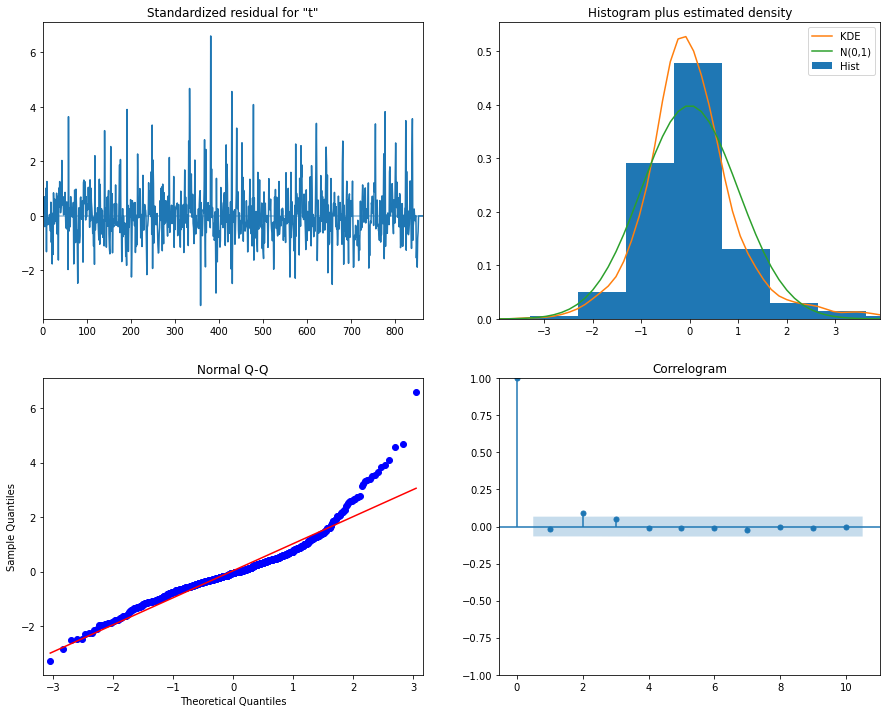

In [32]:
modelFit.plot_diagnostics(figsize=(15, 12))
plt.show()

1 year prediction: original data vs predictions figsize=(20, 15)

In [35]:
prediction = modelFit.get_prediction(start=pd.to_datetime('2020-05-15'), dynamic=False)
pred_conf = prediction.conf_int()

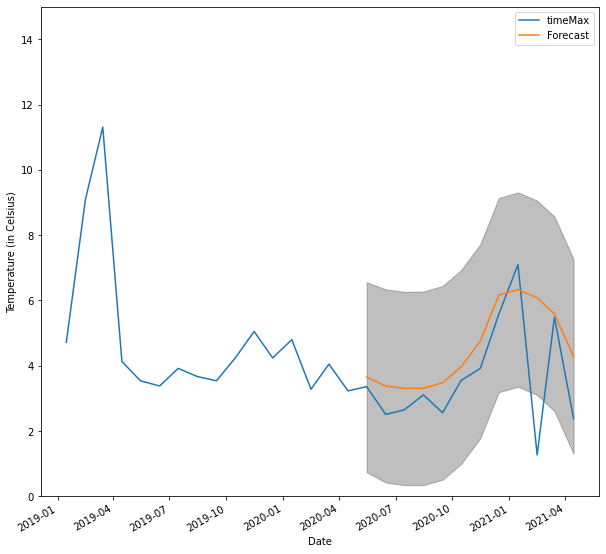

In [37]:
xx = dfMax['2019':].plot(label='observed', figsize=(10, 10))
prediction.predicted_mean.plot(ax=xx, label='Forecast')

xx.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=.25)

xx.set_xlabel('Date')
xx.set_ylabel('Temperature (in Celsius)')
plt.ylim([-0,15])
plt.legend()
plt.show()

In [39]:
pred = prediction.predicted_mean
mse = MSE(test, pred, squared=True)
print('The Mean Squared Error of the prediction is {}'.format(round(mse, 2)))

The Mean Squared Error of the prediction is 2.56


MSE of 2.56 seems accetable